# Gradient Descent Method Example

## Import the required libraries

In [ ]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import itertools
from IPython.display import display

## Define the functions

In [2]:
L = pf.Parameter("L")
f = pf.SmoothConvexFunction(is_basis=True, tags=["f"], L=L)

## Write a function to return the PEPContext associated with GD

In [3]:
def make_ctx_gd(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_gd = pf.PEPContext(ctx_name).set_as_current()
    x = pf.Vector(is_basis=True, tags=["x_0"])
    f.set_stationary_point("x_star")
    for i in range(N):
        x = x - 1 / L * f.grad(x)
        x.add_tag(f"x_{i + 1}")
    return ctx_gd

## Numerical evidence of convergence of GD

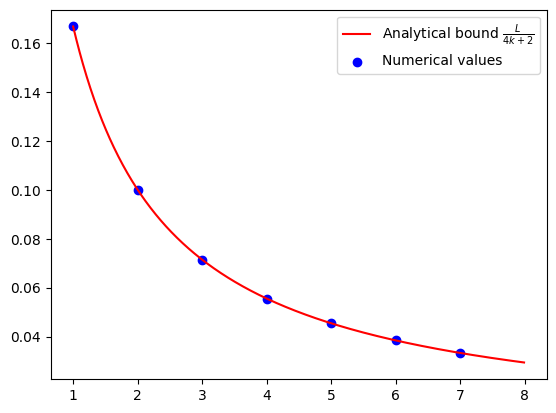

In [4]:
N = 8
R = pf.Parameter("R")
L_value = 1
R_value = 1

ctx_plt = make_ctx_gd(ctx_name="ctx_plt", N=N, stepsize=1 / L)
pb_plt = pf.PEPBuilder(ctx_plt)
pb_plt.add_initial_constraint(
    ((ctx_plt["x_0"] - ctx_plt["x_star"]) ** 2).le(R, name="initial_condition")
)

opt_values = []
for k in range(1, N):
    x_k = ctx_plt[f"x_{k}"]
    pb_plt.set_performance_metric(f(x_k) - f(ctx_plt["x_star"]))
    result = pb_plt.solve(resolve_parameters={"L": L_value, "R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N)
cont_iters = np.arange(1, N, 0.01)
plt.plot(
    cont_iters,
    L_value / (4 * cont_iters + 2),
    "r-",
    label="Analytical bound $\\frac{L}{4k + 2}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of GM

In [5]:
N = sp.S(2)
L_value = sp.S(1)
R_value = sp.S(1)

ctx_prf = make_ctx_gd(ctx_name="ctx_prf", N=N, stepsize=1 / L)
pb_prf = pf.PEPBuilder(ctx_prf)
pb_prf.add_initial_constraint(
    ((ctx_prf["x_0"] - ctx_prf["x_star"]) ** 2).le(R, name="initial_condition")
)
pb_prf.set_performance_metric(f(ctx_prf[f"x_{N}"]) - f(ctx_prf["x_star"]))

result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(f)

0.09999778825848689


In [6]:
pf.launch_primal_interactive(
    pb_prf, ctx_prf, resolve_parameters={"L": L_value, "R": R_value}
)

Dash app running on http://127.0.0.1:8050/


### Solve the problem again with the found relaxation

In [7]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_star" as "N+1 where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx)
    elif idx == "star":
        return N + 1

In [8]:
relaxed_constraints = []

for tag_i in lamb_dense.row_names:
    i = tag_to_index(tag_i)
    if i == N + 1:
        continue
    for tag_j in lamb_dense.col_names:
        j = tag_to_index(tag_j)
        if i < N and i + 1 == j:
            continue
        relaxed_constraints.append(f"f:{tag_i},{tag_j}")

pb_prf.set_relaxed_constraints(relaxed_constraints)

- Solve the PEP problem again with the relaxed constraints and store the results.


In [9]:
result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})

# Dual variable associated with the initial condition
tau_sol = result.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of f
lamb_sol = result.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variable associated with the Gram matrix G
S_sol = result.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

- Print the values of $\lambda$ obtained from the solver

In [10]:
lamb_sol.pprint()

<IPython.core.display.Math object>

In [11]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N + 1:  # Additional constraint 1 (between x_★)
        if j == 0:
            return lamb("x_0", "x_1")
        elif j < N:
            return lamb(f"x_{j}", f"x_{j + 1}") - lamb(f"x_{j - 1}", f"x_{j}")
        elif j == N:
            return 1 - lamb(f"x_{N - 1}", f"x_{N}")
    if i < N and i + 1 == j:  # Additional constraint 2 (consecutive)
        return j / (2 * N + 1 - j)
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether our candidate of $\lambda$ matches with solution

In [12]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of lambda? True


### Verify closed form expression $S$

- Create an ExpressionManager to translate $x_i$, $f(x_i)$, and $\nabla f(x_i)$ into a basis representation

In [13]:
pm = pf.ExpressionManager(ctx_prf, resolve_parameters={"L": L_value, "R": R_value})

- Print the values of $S$ obtained from the solver

In [14]:
S_sol.pprint()

<IPython.core.display.Math object>

- Subtract the decomposed closed-form expressions

In [15]:
x = ctx_prf.tracked_point(f)
x_0 = ctx_prf["x_0"]
x_star = ctx_prf["x_star"]

In [16]:
tau_cand = L / sp.S(4 * N + 2)

grad_terms = sum(lamb(x_star.tag, x[i].tag) * f.grad(x[i]) for i in range(N + 1))
z_N = x_star - x_0 + 1 / (2 * tau_cand) * grad_terms
iter_diff_square = tau_cand * z_N**2

remainder_1 = S_sol.matrix - pm.eval_scalar(iter_diff_square).inner_prod_coords
pf.pprint_labeled_matrix(remainder_1, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [17]:
grad_diff_square = pf.Scalar.zero()
for i in range(N + 1):
    for j in range(i + 1, N + 1):
        const_1 = (2 * N + 1) * lamb(x_star.tag, x[i].tag) - 1
        const_2 = lamb(x_star.tag, x[j].tag)
        grad_diff_square += (
            1 / (2 * L) * (const_1 * const_2 * (f.grad(x[i]) - f.grad(x[j])) ** 2)
        )

remainder_2 = remainder_1 - pm.eval_scalar(grad_diff_square).inner_prod_coords
pf.pprint_labeled_matrix(remainder_2, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [18]:
S_guess = iter_diff_square + grad_diff_square
S_guess_eval = pm.eval_scalar(S_guess).inner_prod_coords
pf.pprint_labeled_matrix(S_guess_eval, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

- Check whether our candidate of $S$ matches with solution

In [19]:
print(
    "Did we guess the right closed form of S?",
    np.allclose(pm.eval_scalar(S_guess).inner_prod_coords, S_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of S? True


### Symbolic calculation

- Assemble the RHS of the proof.

In [20]:
interp_scalar_sum = pf.Scalar.zero()
for x_i, x_j in itertools.product(x, x):
    if lamb(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += lamb(x_i.tag, x_j.tag) * f.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+1/4*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2/3*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+1/4*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+5/12*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+1/3*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)

In [21]:
RHS = interp_scalar_sum - S_guess
display(RHS)

0+1/4*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2/3*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+1/4*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+5/12*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+1/3*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)-(L/10*|x_star-x_0+1/2*L/10*(1/4*grad_f(x_0)+5/12*grad_f(x_1)+1/3*grad_f(x_2))|^2+0+1/2*L*5/48*|grad_f(x_0)-grad_f(x_1)|^2+1/2*L*1/12*|grad_f(x_0)-grad_f(x_2)|^2+1/2*L*13/36*|grad_f(x_1)-grad_f(x_2)|^2)

- Assemble the LHS of the proof

In [22]:
LHS = f(x[N]) - f(x_star) - L / (4 * N + 2) * (x[0] - x_star) ** 2
display(LHS)

f(x_2)-f(x_star)-L/10*|x_0-x_star|^2

In [23]:
diff = LHS - RHS
display(diff)

f(x_2)-f(x_star)-L/10*|x_0-x_star|^2-(0+1/4*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2/3*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+1/4*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+5/12*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+1/3*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)-(L/10*|x_star-x_0+1/2*L/10*(1/4*grad_f(x_0)+5/12*grad_f(x_1)+1/3*grad_f(x_2))|^2+0+1/2*L*5/48*|grad_f(x_0)-grad_f(x_1)|^2+1/2*L*1/12*|grad_f(x_0)-grad_f(x_2)|^2+1/2*L*13/36*|grad_f(x_1)-grad_f(x_2)|^2))

In [24]:
pf.pprint_str(
    diff.repr_by_basis(ctx_prf, sympy_mode=True, resolve_parameters={"L": sp.S("L")})
)

<IPython.core.display.Math object>

---

#### With verified closed form expression, we have verified the below for fixed $N$

\begin{align*}
    &f(x_N) - f(x_\star) - \frac{L}{4N+2} \| x_0 - x_\star \|^2  \\
    &= \sum _{i=1}^N \lambda_{i,i-1} \left( f(x_{i})-f(x_{i-1}) + \langle \nabla f(x_{i}) , x_{i-1} - x_{i} \rangle + \frac{1}{2 L} \| \nabla f(x_{i-1}) - \nabla f(x_i) \|^2 \right)  \\ 
    &\quad +\sum _{i=0}^N \lambda_{\star,i} \left( f(x_i)-f(x_{\star}) + \langle \nabla f(x_{i}) , x_{\star} - x_{i} \rangle + \frac{1}{2 L} \| \nabla f(x_i) \|^2 \right) \\
    &\quad - \frac{1}{2L} \sum_{i=0}^N \sum_{j=i+1}^N \lambda_{\star,j} \left( (2N+1) \lambda_{\star,i} - 1 \right) \| \nabla f(x_j) -\nabla f(x_i) \|^2 \\
     &\quad-  \frac{L}{4N+2} \left\| x_0 - \frac{2N+1}{L} \sum_{i=0}^{N} \lambda_{\star,i} \nabla f(x_i) - x_\star \right\|^2 
\end{align*}
where 
\begin{align*}
\lambda_{i-1,i} = \frac{i}{2N + 1 - i}, \quad i = 1, \dots, N,
\qquad
\lambda_{\star,i} =
\begin{cases}
\lambda_{0,1} & i = 0 \\
\lambda_{i,i+1} - \lambda_{i-1,i} & i = 1, \dots, N-1 \\
1 - \lambda_{i-1,i} & i = N
\end{cases}
\end{align*}